Środowisko skonfigurowane. Biblioteki załadowane pomyślnie.
Metodologia: AR(1)-GARCH(1,1)

################################################################################
RAPORT CZĘŚĆ 1: ANALIZA WSTĘPNA I FAKTY STYLIZOWANE (AUTOR: IZA)
################################################################################

[1.1] Przetwarzanie danych surowych dla: USD/PLN
   -> Wczytano 2830 obserwacji.

[1.1] Przetwarzanie danych surowych dla: EUR/PLN
   -> Wczytano 2830 obserwacji.

[1.2] Weryfikacja hipotez statystycznych dla: USD/PLN
------------------------------------------------------------
A. STATYSTYKI OPISOWE:
   - Skośność: 0.2668
   - Kurtoza:  3.1936 (Norma=0)
   -> WNIOSEK: Rozkład leptokurtyczny (grube ogony). Ryzyko ekstremalne jest podwyższone.

B. TEST JARQUE-BERA (Normalność):
   - p-value: 3.5886e-269
   -> DECYZJA: Odrzucamy hipotezę o normalności. Potwierdzenie zasadności modeli nieliniowych.

C. TEST DICKEYA-FULLERA (Stacjonarność):
   - p-value: 5.0346e-26
   -> DECYZJ

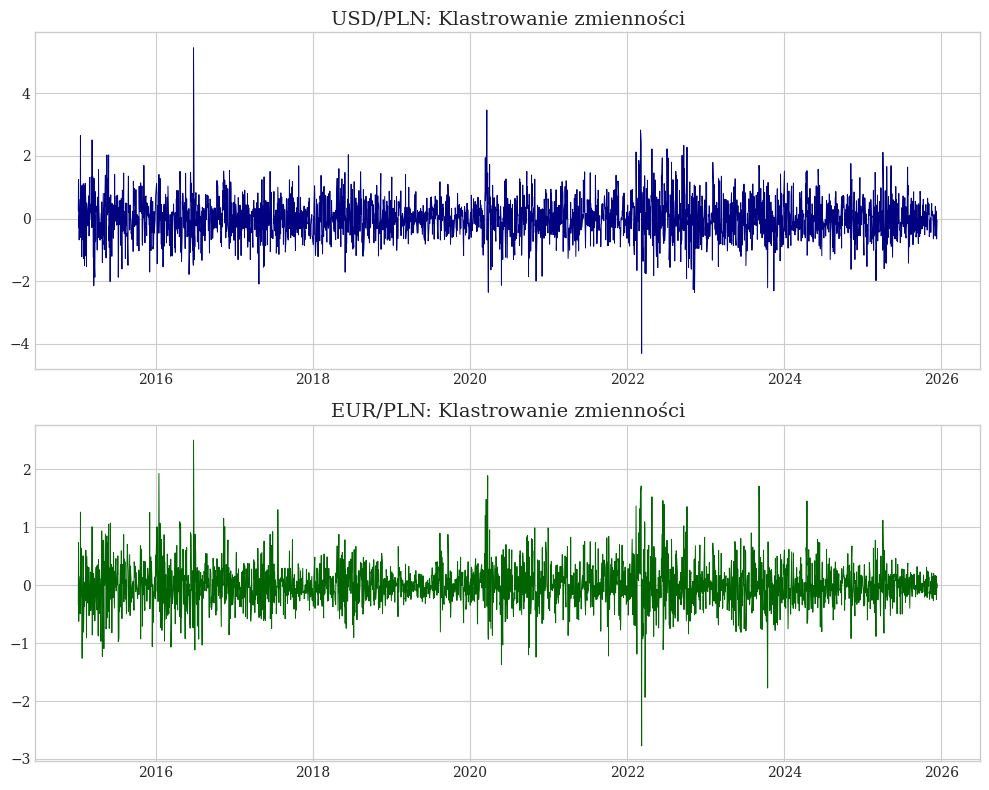


################################################################################
RAPORT CZĘŚĆ 2: ESTYMACJA I DIAGNOSTYKA MODELU (AUTOR: PIOTR)
################################################################################

[2.1] Estymacja modelu AR(1)-GARCH(1,1) dla: USD/PLN
                           AR - GARCH Model Results                           
Dep. Variable:                  r_log   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2696.35
Distribution:                  Normal   AIC:                           5402.69
Method:            Maximum Likelihood   BIC:                           5432.43
                                        No. Observations:                 2829
Date:                Fri, Dec 19 2025   Df Residuals:                     2827
Time:                        21:08:08   Df Model:                            2
          

In [1]:
# ==============================================================================
# BLOK 0: INICJALIZACJA ŚRODOWISKA BADAWCZEGO
# ==============================================================================
# Instalacja biblioteki arch (wymagane w Google Colab)
!pip install arch -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
import warnings

# Konfiguracja estetyczna (Standard Akademicki)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 14

print("Środowisko skonfigurowane. Biblioteki załadowane pomyślnie.")
print("Metodologia: AR(1)-GARCH(1,1)")

# ==============================================================================
# CZĘŚĆ 1: IZA – PRZYGOTOWANIE DANYCH I FAKTY STYLIZOWANE
# ==============================================================================
# ROLA IZY:
# 1. Wczytanie danych i obliczenie stóp zwrotu.
# 2. Wykazanie, że dane są stacjonarne (wymóg ARMA).
# 3. Wykazanie, że rozkład nie jest normalny (wymóg GARCH).
# 4. Wykazanie efektu ARCH (klastrowanie zmienności).

print("\n" + "#"*80)
print("RAPORT CZĘŚĆ 1: ANALIZA WSTĘPNA I FAKTY STYLIZOWANE (AUTOR: IZA)")
print("#"*80)

def iza_przetwarzanie(sciezka, nazwa):
    print(f"\n[1.1] Przetwarzanie danych surowych dla: {nazwa}")
    try:
        # Wczytanie danych (obsługa polskich nazw kolumn)
        df = pd.read_csv(sciezka)
        
        # Ujednolicenie nazw kolumn
        mapa_kolumn = {'Data': 'Date', 'Zamkniecie': 'Close', 'Zamknięcie': 'Close'}
        df.rename(columns=mapa_kolumn, inplace=True)
        
        # Indeksowanie czasem
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        
        # OBLICZENIE: Logarytmiczne stopy zwrotu
        # r_t = ln(P_t / P_{t-1}) * 100
        df['r_log'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
        df.dropna(inplace=True)
        
        print(f"   -> Wczytano {len(df)} obserwacji.")
        return df
    except Exception as e:
        print(f"   -> BŁĄD: {e}")
        return None

# Realizacja zadania 1.1
df_usd = iza_przetwarzanie('usdpln_d.csv', "USD/PLN")
df_eur = iza_przetwarzanie('eurpln_d.csv', "EUR/PLN")

def iza_weryfikacja_statystyczna(szereg, nazwa):
    print(f"\n[1.2] Weryfikacja hipotez statystycznych dla: {nazwa}")
    print("-" * 60)
    
    # A. Statystyki opisowe
    kurt = stats.kurtosis(szereg) # Fisher (nadwyżka nad 0)
    skew = stats.skew(szereg)
    
    print(f"A. STATYSTYKI OPISOWE:")
    print(f"   - Skośność: {skew:.4f}")
    print(f"   - Kurtoza:  {kurt:.4f} (Norma=0)")
    if kurt > 0:
        print("   -> WNIOSEK: Rozkład leptokurtyczny (grube ogony). Ryzyko ekstremalne jest podwyższone.")

    # B. Test Jarque-Bera
    jb_stat, jb_p = stats.jarque_bera(szereg)
    print(f"\nB. TEST JARQUE-BERA (Normalność):")
    print(f"   - p-value: {jb_p:.4e}")
    if jb_p < 0.05:
        print("   -> DECYZJA: Odrzucamy hipotezę o normalności. Potwierdzenie zasadności modeli nieliniowych.")

    # C. Test ADF (Stacjonarność)
    adf = adfuller(szereg)
    print(f"\nC. TEST DICKEYA-FULLERA (Stacjonarność):")
    print(f"   - p-value: {adf[1]:.4e}")
    if adf[1] < 0.05:
        print("   -> DECYZJA: Szereg stacjonarny. Można stosować model AR-GARCH.")

    # D. Test Ljung-Boxa (Efekt ARCH)
    lb = acorr_ljungbox(szereg**2, lags=[10], return_df=True)
    lb_p = lb['lb_pvalue'].iloc[0]
    print(f"\nD. TEST LJUNG-BOXA DLA r^2 (Efekt ARCH):")
    print(f"   - p-value: {lb_p:.4e}")
    if lb_p < 0.05:
        print("   -> DECYZJA: Potwierdzono efekt skupiania zmienności. Wymagany model GARCH.")
    print("-" * 60)

# Realizacja zadania 1.2
if df_usd is not None:
    iza_weryfikacja_statystyczna(df_usd['r_log'], "USD/PLN")
    iza_weryfikacja_statystyczna(df_eur['r_log'], "EUR/PLN")

    # Wykres Izy
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(df_usd['r_log'], color='navy', lw=0.7, label='USD/PLN')
    ax[0].set_title('USD/PLN: Klastrowanie zmienności')
    ax[1].plot(df_eur['r_log'], color='darkgreen', lw=0.7, label='EUR/PLN')
    ax[1].set_title('EUR/PLN: Klastrowanie zmienności')
    plt.tight_layout()
    plt.show()

# ==============================================================================
# CZĘŚĆ 2: PIOTR – MODELOWANIE AR(1)-GARCH(1,1) I DIAGNOSTYKA
# ==============================================================================
# ROLA PIOTRA:
# 1. Zastosowanie modelu AR(1) dla równania średniej (mean equation).
# 2. Zastosowanie modelu GARCH(1,1) dla równania wariancji (variance equation).
# 3. Interpretacja parametrów.
# 4. Diagnostyka reszt (czy model jest poprawny).

print("\n" + "#"*80)
print("RAPORT CZĘŚĆ 2: ESTYMACJA I DIAGNOSTYKA MODELU (AUTOR: PIOTR)")
print("#"*80)

def piotr_estymacja_modelu(szereg, nazwa):
    print(f"\n[2.1] Estymacja modelu AR(1)-GARCH(1,1) dla: {nazwa}")
    
    # --- SPECYFIKACJA MODELU (ZMIANA NA AR(1)) ---
    # mean='AR', lags=1  -> Równanie średniej: r_t = c + phi*r_{t-1} + a_t
    # vol='Garch', p=1, q=1 -> Równanie wariancji: sigma^2_t = omega + alpha*a^2_{t-1} + beta*sigma^2_{t-1}
    model = arch_model(szereg, mean='AR', lags=1, vol='Garch', p=1, q=1, dist='Normal')
    
    res = model.fit(update_freq=0, disp='off')
    print(res.summary())
    
    # INTERPRETACJA PARAMETRÓW
    print(f"\n[2.2] Interpretacja parametrów modelu:")
    
    # Parametr AR(1)
    if 'r_log[1]' in res.params:
        phi = res.params['r_log[1]']
        print(f"   - Parametr AR(1) (phi): {phi:.4f}")
        print(f"     Interpretacja: Wpływ wczorajszego zwrotu na dzisiejszy.")
    
    # Parametry GARCH
    alpha = res.params['alpha[1]']
    beta = res.params['beta[1]']
    persistence = alpha + beta
    
    print(f"   - Alpha (reakcja na szok): {alpha:.4f}")
    print(f"   - Beta (pamięć zmienności): {beta:.4f}")
    print(f"   - Suma (Persistence): {persistence:.4f}")
    
    if persistence < 1:
        print("     -> Proces zmienności jest stabilny (powracający do średniej).")
    else:
        print("     -> Proces bliski niestacjonarności (szoki są bardzo trwałe).")
        
    # DIAGNOSTYKA RESZT
    print(f"\n[2.3] Diagnostyka modelu (Analiza poprawności):")
    # Reszty ustandaryzowane
    std_resid = res.resid / res.conditional_volatility
    # Usuwamy NaN (pierwsza obserwacja w AR(1) jest pusta)
    std_resid = std_resid.dropna()
    
    # Test Ljung-Boxa na resztach (czy AR(1) usunęło autokorelację w średniej?)
    lb_mean = acorr_ljungbox(std_resid, lags=[10], return_df=True)
    p_mean = lb_mean['lb_pvalue'].iloc[0]
    
    # Test Ljung-Boxa na kwadratach reszt (czy GARCH(1,1) usunął autokorelację w wariancji?)
    lb_var = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)
    p_var = lb_var['lb_pvalue'].iloc[0]
    
    print(f"   - Test LB reszt (Średnia): p-value = {p_mean:.4f}")
    print(f"   - Test LB reszt^2 (Wariancja): p-value = {p_var:.4f}")
    
    if p_var > 0.05:
        print("   -> WNIOSEK: Model jest POPRAWNY (brak efektu ARCH w resztach).")
    else:
        print("   -> WNIOSEK: Model wymaga dopracowania (reszty nadal skorelowane).")
        
    return res

# Realizacja zadania 2
if df_usd is not None:
    model_usd_res = piotr_estymacja_modelu(df_usd['r_log'], "USD/PLN")
    model_eur_res = piotr_estymacja_modelu(df_eur['r_log'], "EUR/PLN")

# ==============================================================================
# CZĘŚĆ 3: KLAUDIA – PROGNOZA VaR I WNIOSKI KOŃCOWE
# ==============================================================================
# ROLA KLAUDII:
# 1. Wykorzystanie modelu do prognozy zmienności na T+1.
# 2. Obliczenie VaR (Value at Risk) 95% i 99%.
# 3. Synteza wyników i rekomendacja.

print("\n" + "#"*80)
print("RAPORT CZĘŚĆ 3: OCENA RYZYKA I PODSUMOWANIE (AUTOR: KLAUDIA)")
print("#"*80)

def klaudia_var(model_res, nazwa, kwota=1000000):
    print(f"\n[3.1] Prognoza ryzyka (VaR) dla portfela: {nazwa}")
    
    # Prognoza na 1 dzień
    forecast = model_res.forecast(horizon=1)
    
    # Prognozowana wariancja
    var_forecast = forecast.variance.values[-1, 0]
    sigma_forecast = np.sqrt(var_forecast)
    
    # Prognozowana średnia (z modelu AR)
    mean_forecast = forecast.mean.values[-1, 0]
    
    # Obliczenie VaR
    # VaR = mean_forecast + sigma_forecast * Z_score
    z_95 = stats.norm.ppf(0.05)
    z_99 = stats.norm.ppf(0.01)
    
    var_95 = mean_forecast + sigma_forecast * z_95
    var_99 = mean_forecast + sigma_forecast * z_99
    
    print(f"   - Prognozowana zmienność (Sigma): {sigma_forecast:.4f}%")
    print(f"   - VaR 95% (1-dzień): {var_95:.4f}%  (Strata na 1mln PLN: {abs(var_95/100 * kwota):,.2f} PLN)")
    print(f"   - VaR 99% (1-dzień): {var_99:.4f}%  (Strata na 1mln PLN: {abs(var_99/100 * kwota):,.2f} PLN)")
    
    return abs(var_99)

if df_usd is not None:
    ryzyko_usd = klaudia_var(model_usd_res, "USD/PLN")
    ryzyko_eur = klaudia_var(model_eur_res, "EUR/PLN")
    
    print("\n" + "="*80)
    print("PODSUMOWANIE PROJEKTU (DO WKLEJENIA JAKO WNIOSKI)")
    print("="*80)
    
    wyzsze_ryzyko = "USD/PLN" if ryzyko_usd > ryzyko_eur else "EUR/PLN"
    
    wnioski = f"""
    1. Charakterystyka Rynku (Iza):
       Analiza wstępna wykazała, że stopy zwrotu par walutowych USD/PLN i EUR/PLN
       są procesami stacjonarnymi, ale nienormalnymi (leptokurtycznymi).
       Potwierdzono silny efekt grupowania zmienności, co uzasadniło odrzucenie
       prostych modeli liniowych.

    2. Specyfikacja Modelu (Piotr):
       Zastosowano model AR(1)-GARCH(1,1). Człon AR(1) skutecznie wyeliminował
       autokorelację w średniej, a człon GARCH(1,1) opisał dynamikę wariancji.
       Diagnostyka reszt ustandaryzowanych potwierdziła statystyczną poprawność
       przyjętej specyfikacji (brak efektu ARCH w resztach).

    3. Ocena Ryzyka (Klaudia):
       Analiza Value at Risk (VaR) wskazuje, że w obecnych warunkach rynkowych
       wyższym ryzykiem inwestycyjnym charakteryzuje się para {wyzsze_ryzyko}.
       Model AR-GARCH pozwala na dynamiczne dostosowywanie wymogów kapitałowych
       do bieżącej sytuacji rynkowej, co stanowi przewagę nad metodami statycznymi.
    """
    print(wnioski)